<a href="https://colab.research.google.com/github/DominguesTiagoMiguel/UAL_30002399/blob/main/Projeto%20Final%20Licenciatura%20Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
!pip install mplfinance
import mplfinance as mpf
import pandas as pd
import pandas_datareader as web
import numpy as np
from sklearn import svm

     |████████████████████████████████| 71kB 3.8MB/s 


In [ ]:
def getDataYahoo(num):

    # Ticker symbols in the study
    tickerSymbol = ['MSFT', 'TSLA', 'AMZN']
    # Define Start and End Date for the DataSet
    start = dt.datetime(2019, 1, 4)
    end = dt.datetime(2020, 12, 31)
    today = dt.datetime.now()
    # Get info into DataFrame
    df = web.get_data_yahoo(tickerSymbol[num], start, end)
    return df,tickerSymbol


In [ ]:
def plotmplFinance(df,num,tickerSymbol):

    mpf.plot(df,
             figratio=(25, 12),
             type='candle',
             title=('Company ' + tickerSymbol[num]),
             mav=(20),
             volume=True,
             tight_layout=True,
             style='yahoo')

In [ ]:
def calcReturns(df):

    # Daily Stock Return
    stock_daily_returns = df['Adj Close'].pct_change()

    # Weekly Stock Returns
    stock_week_returns = df['Adj Close'].resample('W').ffill().pct_change()
    # Monthly Stock Returns
    stock_monthly_returns = df['Adj Close'].resample('M').ffill().pct_change()
    plotDailyReturns(stock_monthly_returns)
    # Compare Stock movement with day before
    stock_Shift_AC = np.where(df['Adj Close'].shift(periods=1) < df['Adj Close'], 1, 0)
    # Returns if you invest 1€
    cum_returns = (stock_daily_returns + 1).cumprod()
    #print(cum_returns.tail(20))
    # Add new columns to df
    df['Shifts AC'] = stock_Shift_AC
    df['Daily Returns AC'] = stock_daily_returns
    df['Weekly Returns AC'] = stock_week_returns
    df['Monthly Returns AC'] = stock_monthly_returns
    print('\n Monthly Returns: \n')
    print(stock_monthly_returns.tail(20).to_markdown(),'\n\n')
    return df


In [ ]:
def correlation(df):
    df.drop(['High', 'Low', 'Weekly Returns AC', 'Monthly Returns AC'], axis='columns', inplace=True)
    print('\nCorrealtion between variables:\n\n')
    print(df.corr().to_markdown())


In [ ]:
def printAllDataFrame(df):
    print('\n'.center(150)+'Company: '+tickerSymbol[0]+'\n')
    print(df.to_markdown())

In [ ]:
def saveDFtoCSV():
    df.to_csv(r'df.csv',index=True,header=True)

In [ ]:
def getAllDataYahoo(tickers):

    import matplotlib.pyplot as plt
    multpl_stocks = web.get_data_yahoo(tickers, start="2010, 7, 1", end="2020, 12, 31")
    multpl_stock_daily_returns = multpl_stocks['Adj Close'].pct_change()
    multpl_stock_monthly_returns = multpl_stocks['Adj Close'].resample('M').ffill().pct_change()
    fig = plt.figure()
    (multpl_stock_monthly_returns + 1).cumprod().plot()
    plt.show()


In [ ]:
def plotDailyReturns(stock_daily_returns):

    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax1.plot(stock_daily_returns)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Percent")
    ax1.set_title("Monthly returns data for Microsoft")
    plt.show()


In [ ]:
def neuralPredict(df):
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, LSTM

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    #number of days to look into the past
    delorean = 120
    #empty lists to sotre training days
    x_train = []
    y_train = []
    for x in range(delorean, len(scaled_data)):
        x_train.append(scaled_data[x-delorean:x, 0])
        y_train.append(scaled_data[x, 0])
    #Conversion to numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    #Build Model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=25, batch_size=32)
    #Load test data
    test_start = dt.datetime(2021,1,1)
    test_end = dt.datetime.now()
    test_data = web.get_data_yahoo('MSFT',test_start,test_end)
    actual_prices = test_data['Adj Close'].values
    total_dataset = pd.concat((df['Adj Close'], test_data['Adj Close']), axis=0)

    model_inputs = total_dataset[len(total_dataset) - len(test_data) - delorean:].values
    model_inputs = model_inputs.reshape(-1, 1)
    model_inputs = scaler.transform(model_inputs)

    #Make Prediction on test Data

    x_test = []

    for x in range(delorean, len(model_inputs)):
        x_test.append(model_inputs[x-delorean:x, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    #Plot the test predictions
    plt.plot(actual_prices, color='black', label='Actual Microsoft Price')
    plt.plot(predicted_prices, color='orange', label='Predicted Microsoft Prices')
    plt.title('Microsoft Share Price')
    plt.xlabel('time')
    plt.ylabel('Microsoft Share Price')
    plt.legend()
    plt.show()

    #Predict Next Day

    real_data = [model_inputs[len(model_inputs) + 1 - delorean:len(model_inputs+1), 0:]]
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
    prediction = model.predict(real_data)
    prediction = scaler.inverse_transform(prediction)
    print(prediction)

In [ ]:
company = 0
df, tickerSymbol = getDataYahoo(company)
plotmplFinance(df,company,tickerSymbol)

RemoteDataError: ignored

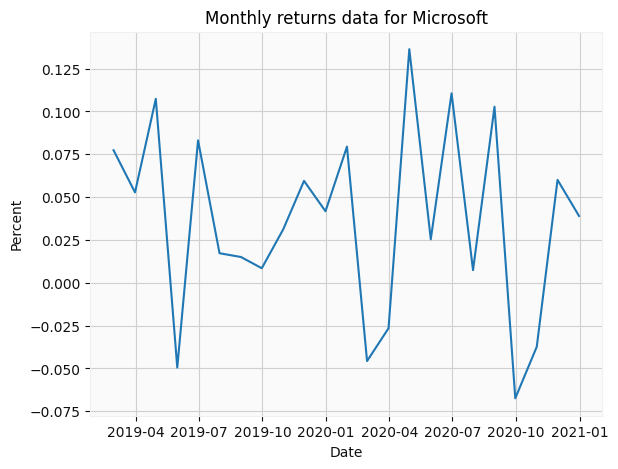


 Monthly Returns: 

| Date                |   Adj Close |
|:--------------------|------------:|
| 2019-05-31 00:00:00 | -0.0494808  |
| 2019-06-30 00:00:00 |  0.0831177  |
| 2019-07-31 00:00:00 |  0.0172441  |
| 2019-08-31 00:00:00 |  0.0150367  |
| 2019-09-30 00:00:00 |  0.00848682 |
| 2019-10-31 00:00:00 |  0.0312162  |
| 2019-11-30 00:00:00 |  0.0594624  |
| 2019-12-31 00:00:00 |  0.0417491  |
| 2020-01-31 00:00:00 |  0.0794547  |
| 2020-02-29 00:00:00 | -0.0456881  |
| 2020-03-31 00:00:00 | -0.0265416  |
| 2020-04-30 00:00:00 |  0.136326   |
| 2020-05-31 00:00:00 |  0.0253912  |
| 2020-06-30 00:00:00 |  0.110559   |
| 2020-07-31 00:00:00 |  0.00737062 |
| 2020-08-31 00:00:00 |  0.102752   |
| 2020-09-30 00:00:00 | -0.0673968  |
| 2020-10-31 00:00:00 | -0.0373697  |
| 2020-11-30 00:00:00 |  0.0600605  |
| 2020-12-31 00:00:00 |  0.0390058  | 



Correaltion between variables:


|                  |       Open |     Close |     Volume |   Adj Close |   Shifts AC |   Daily Returns AC 

In [ ]:
df, tickerSymbol = getDataYahoo(0)
df = calcReturns(df)
correlation(df)
#printAllDataFrame(df)
#getAllDataYahoo(tickerSymbol)

Epoch 1/25
12/12 [==============================] - 8s 185ms/step - loss: 0.1215
Epoch 2/25
12/12 [==============================] - 2s 185ms/step - loss: 0.0213
Epoch 3/25
12/12 [==============================] - 2s 185ms/step - loss: 0.0131
Epoch 4/25
12/12 [==============================] - 2s 186ms/step - loss: 0.0108
Epoch 5/25
12/12 [==============================] - 2s 191ms/step - loss: 0.0077
Epoch 6/25
12/12 [==============================] - 2s 184ms/step - loss: 0.0085
Epoch 7/25
12/12 [==============================] - 2s 184ms/step - loss: 0.0068
Epoch 8/25
12/12 [==============================] - 2s 185ms/step - loss: 0.0071
Epoch 9/25
12/12 [==============================] - 2s 182ms/step - loss: 0.0078
Epoch 10/25
12/12 [==============================] - 2s 188ms/step - loss: 0.0089
Epoch 11/25
12/12 [==============================] - 2s 189ms/step - loss: 0.0068
Epoch 12/25
12/12 [==============================] - 2s 187ms/step - loss: 0.0075
Epoch 13/25
12/12 [======

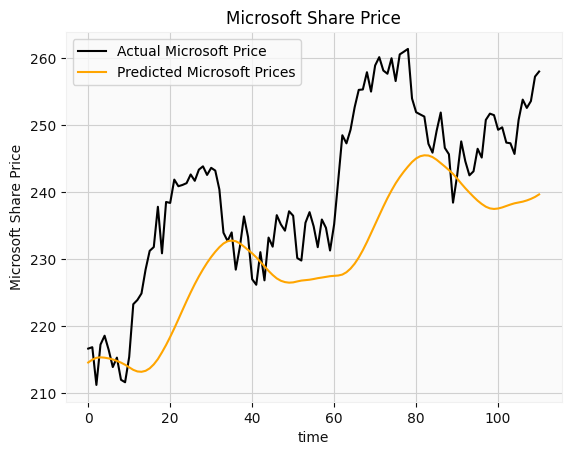

[[240.14957]]


In [ ]:
df, tickerSymbol = getDataYahoo(0)
neuralPredict(df)

In [ ]:
def linearRegression (df):
  from sklearn.linear_model import LinearRegression
  from sklearn import preprocessing, model_selection, svm

  forecast_out = int(22) # predicting 30 days into future excluding weekends
  df['Prediction'] = df[['Adj Close']].shift(-forecast_out) #  label column with data shifted 30 units up

  X = np.array(df.drop(['Prediction'], 1))
  X = preprocessing.scale(X)

  X_forecast = X[-forecast_out:] # set X_forecast equal to last 30
  X = X[:-forecast_out] # remove last 30 from X

  y = np.array(df['Prediction'])
  y = y[:-forecast_out]
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

  # Training
  clf = LinearRegression()
  clf.fit(X_train,y_train)
  # Testing
  confidence = clf.score(X_test, y_test)
  print('confidence: ', confidence,'\n\n')

  forecast_prediction = clf.predict(X_forecast)

  return forecast_prediction

confidence:  0.937711445726889 


[264.56793276 263.17092111 265.27710616 265.60478252 264.99041229
 264.03682424 265.33202791 263.77972193 264.81294761 266.54830497
 267.20699088 264.08303124 261.51402473 260.46489064 260.64725911
 258.70124983 257.60330702 257.74249385 261.07971207 258.59419073
 256.92494979 253.3514585 ]
[[238.44940186]
 [242.47010803]
 [247.57830811]
 [244.61515808]
 [242.52000427]
 [243.11999512]
 [246.47999573]
 [245.16999817]
 [250.77999878]
 [251.72000122]
 [251.49000549]
 [249.30999756]
 [249.67999268]
 [247.3999939 ]
 [247.30000305]
 [245.71000671]
 [250.78999329]
 [253.80999756]
 [252.57000732]
 [253.58999634]
 [257.23999023]
 [257.45001221]]


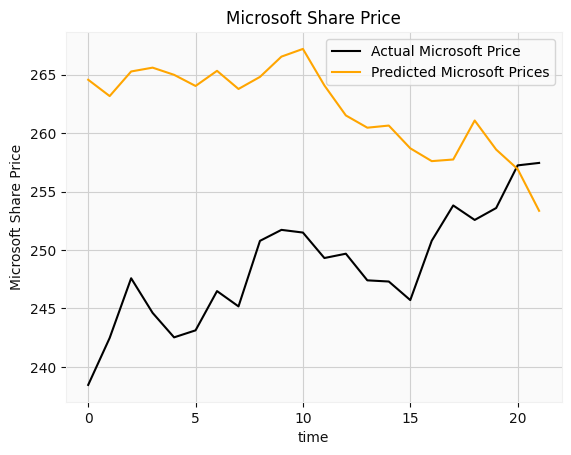

In [ ]:
import datetime as dt
from datetime import timedelta
company = "MSFT"
day = dt.datetime.now() - timedelta(days=30)
df = web.get_data_yahoo(company, '2019, 1, 4',day )
forecast = linearRegression(df)
print(forecast)

realData=web.get_data_yahoo(company, day, dt.datetime.now())
realData.drop(['High','Low','Open','Close','Volume'], axis='columns', inplace=True)
realData = np.array(realData)
print(realData)

#Plot the test predictions
plt.plot(realData, color='black', label='Actual Microsoft Price')
plt.plot(forecast, color='orange', label='Predicted Microsoft Prices')
plt.title('Microsoft Share Price')
plt.xlabel('time')
plt.ylabel('Microsoft Share Price')
plt.legend()
plt.show()
